In [1]:
import sys
sys.path.append('../../src')

from common import common, transform, json
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Indivisual Activity をロード

In [100]:
room_num = '09'
date = '20210304'
name = 'gaze3-3'

In [101]:
individual_activity_json = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [102]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo = transform.Homography(p_video, p_field, field_raw.shape)

In [103]:
individual_activity_data = json.load(individual_activity_json)

In [104]:
from common.json import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        for key in IA_FORMAT[3:]:
            ia.indicator_dict[key][frame_num] = data[key]
            
    return list(individuals.values())

In [105]:
individuals = make_individuals(individual_activity_data, homo)

#　対象物を予測する
1. 各個人のポジションと対象物の線と顔の向きのコサイン類似度を求める
2. コサイン類似度が0に近い対象物を視線の先の対象物とする

In [106]:
from common.functions import normalize_vector, cos_similarity

In [107]:
manual_results = {
    'gaze1-1': {'frame': 350, 'order': [0, 2, 1]},
    'gaze1-2': {'frame': 310, 'order': [0, 1, 2]},
    'gaze1-3': {'frame': 275, 'order': [0, 1, 2]},
    'gaze2-1': {'frame': 276, 'order': [0, 1, 2]},
    'gaze2-2': {'frame': 286, 'order': [0, 1, 2]},
    'gaze2-3': {'frame': 283, 'order': [0, 1, 2]},
    'gaze3-1': {'frame': 311, 'order': [0, 1, 2]},
    'gaze3-2': {'frame': 297, 'order': [0, 1, 2]},
    'gaze3-3': {'frame': 305, 'order': [0, 1, 2]},
}

object_points = {
    1: (679, 772),  # monitor
    2: (54, 772),   # PC
    3: (368, 420),  # operating table
}

In [108]:
def predict_object(individuals):
    max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])
    
    predict = []
    for frame_num in range(max_frame_num):
        objects = []
        for i, individual in enumerate(individuals):
            position = individual.get_data('position', frame_num)
            face = individual.get_data('face_vector', frame_num)

            if position is None or face is None:
                continue

            max_cos = -1
            max_label = 0
            for label, obj in object_points.items():
                pos2obj = np.array(obj) - position
                pos2obj = normalize_vector(pos2obj.astype(float))
                cos = cos_similarity(face, pos2obj)

                if max_cos < cos:
                    max_cos = cos
                    max_label = label
                
            objects.append(max_label)
            
        predict.append(objects)

    return predict

In [109]:
pred_objs = predict_object(individuals)

In [110]:
pred_objs[-1]

[2, 2, 2]

# 検証・評価

In [111]:
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

test_y = []
for row in csv_data:
    test_y.append(row[4])

In [112]:
pred = []
for p, y in zip(pred_objs, test_y):
    likelihood = len(np.where(p == y)[0]) / len(p)
    pred.append(likelihood)
    
test_y = np.array(test_y)
true_y = test_y == test_y[-1]

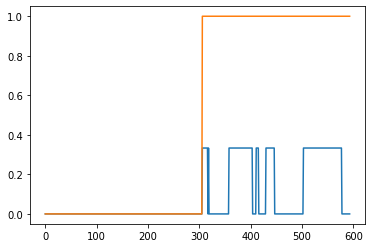

In [113]:
plt.plot(pred)
plt.plot(true_y)

In [114]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy: 0.515
precision: 0.000
recall: 0.000
f1_score: 0.000


/Users/koji/program/research/.venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

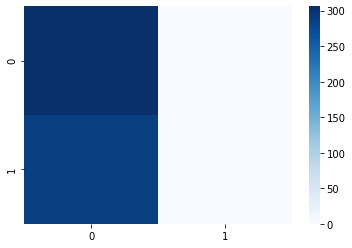

In [115]:
pred = (np.array(pred) == 1) * 1
print('accuracy: {:.3f}'.format(accuracy_score(true_y, pred)))
print('precision: {:.3f}'.format(precision_score(true_y, pred)))
print('recall: {:.3f}'.format(recall_score(true_y, pred)))
print('f1_score: {:.3f}'.format(f1_score(true_y, pred)))

cm = confusion_matrix(true_y, pred)
sns.heatmap(cm, cmap='Blues')